In [103]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import operator
import timeit
from bisect import bisect
%matplotlib inline

In [148]:
class TSP(object):
    def __init__(self,start=1,dissipation=.2,tolerance=.2,alpha=1.0,beta=1.0,explore=1.0,n_cities=4):
        #inputs
        self.n_cities=n_cities
        self.dissipation=dissipation
        self.explore=explore
        self.tolerance=tolerance
        self.alpha=alpha
        self.beta=beta
        self.start=start
        self.step=0
        
        #setup
        self.history_d={} #holds decisions about node order
        self.history_k={}
        self.history_s={}
        self.tsp=self.init_tsp_big(self.n_cities)
        #self.tsp=tsp_single()
        
        #Tracking - last[type][element][node history]
        ##type - p, dist, score, route, dec
        ##element - edge, edge, step, obj, none
        self.last={'p':{},'dist':{},'score':{},'route':{},'dec':{}}
        for e in self.tsp.edges():
            self.last['p'][e]=[]
            self.last['dist'][e]=[]
        for i in xrange(self.tsp.number_of_nodes()-1):
            self.last['route'][i]=[]
        self.last['score'][0]=[]
        self.last['dec'][0]=[] #zero is placeholder
        
        self.d=[int(self.start)]
        #self.d=[]
        self.d_change=[]
        self.history_d[self.step]=list(self.d)
        self.state=self.init_graph(self.tsp)
        self.history_s[self.step]=self.state.copy()
        self.k=self.init_k(self.state)
        #self.last_solution={}
    
    
    def init_tsp_big(self,num_cities=5):
        """
        Nine cities, with a shortest path of 8
        Adjacent cities have dist=1
        Otherwise cities dist are the average of their node labels
        """
        tsp=nx.DiGraph()
        n_l=range(1,num_cities+1)
        tsp.add_nodes_from(n_l)
        #Edges:
        #Non-adjacent edges: Distance=average of node labels
        for i in tsp.nodes():
            for j in tsp.nodes():
                if i!=j:
                    #tsp.add_edge(i,j,dist=(i+j)/2.0)
                    tsp.add_edge(i,j,dist=float(abs(i-j)))
        
        
        
        #Distance=1 for nodes to the right and left
        for i in xrange(len(n_l)):
            n=n_l[i]
            i_l=(i-1)%len(n_l)
            n_left=n_l[i_l]
            i_r=(i+1)%len(n_l)
            n_right=n_l[i_r]
            #print i, i_l,i_r, (n_l[i],n_l[i_l],n_l[i_r])
            #tsp.add_edges_from([(n,n_left,{'dist':1.0}),(n,n_right,{'dist':1.0})])
        
        #infinite distance between first and last
        n=n_l[0]
        n_left=n_l[-1]
        #tsp.add_edges_from([(n,n_left,{'dist':100.0}),(n_left,n,{'dist':100.0})])

        #print tsp.edges(data=True)
        #start node
        tsp.add_node(0)
        for n in tsp.nodes():
            if n!=0:
                tsp.add_edge(0,n,dist=1.0)
        
        #print tsp.edges(data=True)

        return tsp
        
    
    def init_tsp(self):
        tsp=nx.DiGraph()
        tsp.add_edge(1,2,dist=1.0)
        tsp.add_edge(2,1,dist=1.0)
        tsp.add_edge(1,3,dist=1.0)
        tsp.add_edge(3,1,dist=1.0)        
        tsp.add_edge(1,4,dist=2.0)
        tsp.add_edge(4,1,dist=2.0)
        tsp.add_edge(2,3,dist=3.0)
        tsp.add_edge(3,2,dist=3.0)
        tsp.add_edge(2,4,dist=4.0)
        tsp.add_edge(4,2,dist=4.0)
        tsp.add_edge(3,4,dist=2.0)
        tsp.add_edge(4,3,dist=2.0)
        
        #start node
        tsp.add_node(0)
        for n in tsp.nodes():
            if n!=0:
                tsp.add_edge(0,n,dist=0.0)
                
        
        return tsp
        
    def init_graph(self,tsp):
        g=tsp.copy()
        for u,v in g.edges():
            g[u][v]['p']=0.5
            g[u][v]['dist']=0.0
            
        #initialize nodes

        #print g.edges(data=True)

        return g

    def init_k(self,g):
        k=nx.DiGraph()
        last_visited={}
        
        #k for edge data
        for u,v,d in g.edges(data=True):
            last_visited[(u,v)]={}
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.last['p'][(u,v)].append(n_label)
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),dist=float(d['dist']),step=self.step)
            self.last['dist'][(u,v)].append(n_label)
            
        #k for decision
        n_label=k.number_of_nodes()+1
        k.add_node(n_label,label='decision', d=list(self.d), step=self.step)
        self.last['dec'][0].append(n_label)
        
        self.history_k[self.step]=k.copy()
        self.step+=1

        return k #,last_visited
    
    def walk(self):
        #initialize
        g=self.state.copy()
        tsp=self.tsp.copy()
        #tabu=[int(self.start)]
        if not self.d:
            tabu=[random.choice(g.nodes())]
        else:
            tabu=[self.d[0]]
            
        for i in xrange(g.number_of_nodes()-1):
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            dec_point=False #checks if this step is affected by a decision
            for n in g.nodes():
                if n not in tabu:
                    n_l.append(n)
                    p_l.append(g[tabu[-1]][n]['p'])
                    
                    if g[tabu[-1]][n]['p']==0.0: #Part of a decision process
                        dec_point=True
                    
                    
                    if g[tabu[-1]][n]['dist']==0.0:
                        h_l.append(self.explore) #10.0
                    else:
                        h_l.append(1.0/g[tabu[-1]][n]['dist'])
                    
            c_l=np.power(p_l,self.alpha)*np.power(h_l,self.beta)
            n_index=self.make_decision(c_l)
            new_n=n_l[n_index]
                
            #update k with edge from tau and dist to edge selection
            n_label=self.k.number_of_nodes()+1
            
            #label is edge number in solution, e is edge added
            self.k.add_node(n_label,label='selection',i=i,e=(tabu[-1],new_n),step=self.step)
            self.last['route'][i].append(n_label)
            
            for e_i in xrange(len(tabu)-1): #iterate through added edges
                #add constraining 
                last=self.last['route'][e_i][-1]
                self.k.add_edge(last,n_label,step=self.step,t=1)
            
            #if influenced by decision, edge from decision not other edge info
            if (dec_point or (len(n_l)==1 and len(self.d)==self.tsp.number_of_nodes())):
                #only edge from decision
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step, t=1)
                
            else:
                for n in n_l: #g.nodes():
                    #if n not in tabu: #only non tabu
                    if n != tabu[-1]: #no self-edge
                        e=(tabu[-1],n)
                        if (e[0],e[1]) not in self.tsp.edges(): #self.last_visited.keys():
                            e=(e[1],e[0])

                        self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step, t=2)
                        if e[0]!=self.start:
                            self.k.add_edge(self.last['dist'][e][-1],n_label,step=self.step, t=2)
                    

                
            #append new node
            tabu.append(new_n)

        score=0.0
        e_r=[tuple(tabu[i:i+2]) for i in xrange(0,len(tabu), 1)]
        del e_r[-1]

        for e in e_r:
            score+=float(tsp[e[0]][e[1]]['dist'])

        return tuple(tabu), score

    def update_edges(self,route,score):
        g_t=self.state.copy()
        g=self.state.copy()
        p=float(self.dissipation)
        tsp=self.tsp.copy()
        
        #print 'before', g_t.edges(data=True)
        #print 'reduction', p
        
        #update k with rout
        #n_label=self.k.number_of_nodes()+1
        #self.k.add_node(n_label,label=route,step=self.step)
        #self.last_solution['route']=n_label
        
        # k edges from tsp edge info to route - now handled in walk
        #for e in self.last_visited:
            #self.k.add_edge(self.last_visited[e]['p'],n_label,step=self.step)
            #self.k.add_edge(self.last_visited[e]['dist'],n_label,step=self.step)
            
        
        e_r=[tuple(route[i:i+2]) for i in xrange(0,len(route), 1)]
        del e_r[-1]
        
        #update distances
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.tsp.edges():
                e=(e[1],e[0])
            
            #update dist in k
            if g_t[e[0]][e[1]]['dist']==0.0: #and e[0]!=self.start: #start is always 0.0
                dist=float(tsp[e[0]][e[1]]['dist'])
                g_t[e[0]][e[1]]['dist']=dist
                
                #update k for changed distance
                n_label=self.k.number_of_nodes()+1
                last_n=self.last['dist'][(e[0],e[1])][-1]
                self.k.add_node(n_label,label=(e[0],e[1]),dist=float(dist),step=self.step)
                self.k.add_edge(last_n,n_label,step=self.step,t=2)
                self.k.add_edge(self.last['route'][sel_index][-1],n_label,step=self.step,t=1)
                
                self.last['dist'][(e[0],e[1])].append(n_label)
                

        #add k for score
        n_label=self.k.number_of_nodes()+1
        self.k.add_node(n_label,label='score',score=score,step=self.step)
        
        #add k from route selections to score
        for sel,n_list in self.last['route'].iteritems():
                self.k.add_edge(n_list[-1],n_label,step=self.step,t=1)
        
        self.last['score'][0].append(n_label)
        
        t_update=1.0/score
        for u,v,d in g_t.edges(data=True):
            #update pheromone
            g_t[u][v]['p']=float(g[u][v]['p'])*(1.0-p)
            
            #update k for pheromone reduction
            last_n=self.last['p'][(u,v)][-1]
            n_label=self.k.number_of_nodes()+1
            self.k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.k.add_edge(last_n,n_label,step=self.step,t=2)
            self.last['p'][(u,v)].append(n_label)
        
        
        
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.tsp.edges():
                e=(e[1],e[0])
            
            #update k for route score for distance
            last_n=self.last['dist'][(e[0],e[1])][-1]
            self.k.add_edge(last_n,self.last['score'][0][-1],step=self.step,t=1)
                
                
            #update pheromones on included edges    
            g_t[e[0]][e[1]]['p']=float(g_t[e[0]][e[1]]['p'])+t_update*p
            
            #update k for pheromone addition - add edge for walk update
            last_n=self.last['p'][(e[0],e[1])][-1]
            self.k.node[last_n]['p']=float(g_t[e[0]][e[1]]['p'])
            #n_label=self.k.number_of_nodes()+1
            #self.k.add_node(n_label,label=(e[0],e[1]),p=float(g_t[e[0]][e[1]]['p']),step=self.step)
            #self.k.add_edge(last_n,n_label,step=self.step)
            self.k.add_edge(self.last['route'][sel_index][-1],last_n,step=self.step,t=2)
            self.k.add_edge(self.last['score'][0][-1],last_n,step=self.step,t=2)
            #self.last_visited[(e[0],e[1])]['p']=n_label
        
        g_t=self.design(g_t,tolerance=self.tolerance)
        
        self.history_d[self.step]=list(self.d)
        self.history_k[self.step]=self.k.copy()
        self.history_s[self.step]=g_t.copy()
        self.step+=1
        #print 'after', g_t.edges(data=True)    
        return g_t

    def design(self,g,tolerance):
        #makes locks-in step in walk if p(1st node)-p(2nd node)
        #g=self.state.copy()
        g_t=g.copy()
        
        while True:
            if len(self.d)==(g.number_of_nodes()):
                break
                
            
            dec_node=self.d[-1]
        
            #Get probabilities
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            for n in g.nodes():
                if (n not in self.d) and (n!=dec_node):
                    n_l.append(n)
                    p_l.append(g[dec_node][n]['p'])
                    #print dec_node,n, n!=dec_node
                    
                    if g[dec_node][n]['dist']==0.0: #only look at explored nodes
                        #h_l.append(0.0)
                        h_l.append(self.explore)
                        #print dec_node,n
                        #n_l.append(n)
                        #p_l.append(g[dec_node][n]['p'])
                        
                    else:
                        #h_l.append(1.0)
                        h_l.append(1.0/g[dec_node][n]['dist'])
                    
            ph_l=np.power(p_l,self.alpha)*np.power(h_l,1.0) #only use pheromone preference
            if sum(ph_l)==0.0:
                perc_l=[1.0/len(ph_l)]*len(ph_l)
            else:
                perc_l=[float(i)/sum(ph_l) for i in ph_l]
            l=list(perc_l)
            #print perc_l
            m_1=l.pop(l.index(max(l)))
            #print l,m_1
            #print m_1-max(l)
            
            if not l: #only one option
                #print 'decision'
                dec_index=perc_l.index(max(perc_l)) #decision index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
                #print 'decision',self.step,dec_node,node,self.d_change
            
                #Eliminate other edge options
                #skip=[int(self.start),dec_node]
                for n in g.nodes():
                    if n not in self.d:
                        if (dec_node,n) in g_t.edges():
                            g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #update k for decision
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                self.last['dec'][0].append(n_label)
                self.d_change.append(self.step)
                
            elif (m_1-max(l))>=tolerance: #prob gap is larger than tolerance 
                #print 'decision',self.step,dec_node
                
                dec_index=perc_l.index(max(perc_l)) #decision index
                #print n_l,dec_index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
                #print dec_node,self.d
                #print 'decision',self.step,dec_node,node,self.d_change
            
                #Eliminate other edge option
                for n in g.nodes():
                    #print n, dec_node, n!=dec_node
                    #print n, skip,n not in skip
                    if n not in self.d:
                        #print n,dec_node
                        if (dec_node,n) in g_t.edges():
                            g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #update k for decision
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                self.last['dec'][0].append(n_label)
                for n in n_l:
                    e=(dec_node,n)
                    self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step,t=2)
                self.d_change.append(self.step)

                #break
            else:
                break
                
        #self.history_d[self.step]=self.d
            
        return g_t  
        

    def make_decision(self,ph_l):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        if sum(ph_l)==0.0:
            percent_list=[1.0/len(ph_l)]*len(ph_l)
        else:
            percent_list = [float(i)/sum(ph_l) for i in ph_l]   
        cumulative_percent=np.cumsum(percent_list)
        #print cumulative_percent

        #Choose decision index
        select_index=bisect(cumulative_percent,np.random.uniform(0,1,1))

        return select_index



    
    





In [188]:
def run_ACO(steps=1000,cities=10,tolerance=1.0,alpha=1.0,beta=1.0,dissipation=0.2,explore=1.0):
    t=TSP(start=0,tolerance=tolerance,alpha=alpha,beta=beta,dissipation=dissipation,explore=explore,n_cities=cities)

    routes=[]
    converge=0
    
    for i in xrange(steps):
        r,s=t.walk()
        routes.append((r,s))
        t.state=t.update_edges(r,s)
        
        #check convergence
        
        if len(routes)>=2:
            if routes[-1]==routes[-2]:
                #print converge
                converge+=1
            else:
                converge=0
        if converge>=20:
            break
        #if len(t.d)==t.state.number_of_nodes():
            #break
        #print t.edges(data=True)
        
    #print routes
    #print t.state.edges(data=True)
    #print t.d
    #print t.d_change

    s=[i[1] for i in routes]
    gen=xrange(len(s))
    plt.scatter(gen,s)
    _=plt.ylim([0.0,max(s)+1.0])
    
    #print "num cities:", n_cities
        
    return t,routes

((0, 7, 8, 9, 10, 2, 1, 3, 4, 5, 6), 18.0)
[0, 7, 8, 9, 10, 2, 1, 3, 4, 5, 6]


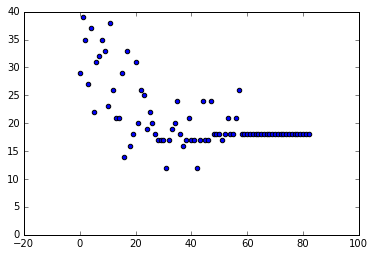

In [191]:
t,routes=run_ACO(steps=1000,cities=10,explore=1.0,tolerance=.8)
print routes[-1]                  
print t.d

In [152]:
print routes[-1],routes[-2]
print routes[-1]==routes[-2]
print len(routes)

((0, 2, 3, 4, 5, 7, 6, 1), 12.0) ((0, 2, 3, 4, 5, 7, 6, 1), 12.0)
True
100


25.6050617026


'\n100,20,72s,yes\n100,15,40s,yes\n\n100,10,16s,yes\n'

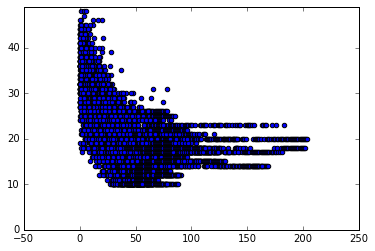

In [189]:
n=100
s=timeit.timeit(run_ACO,number=n)
print s/n

#steps:cities:time:converge
"""
100,20,72s,yes
100,15,40s,yes

100,10,16s,yes
"""

In [105]:
def costly_func():
    return map(lambda x: x^2, range(10))

timeit.timeit(costly_func)

1.8117196924499694

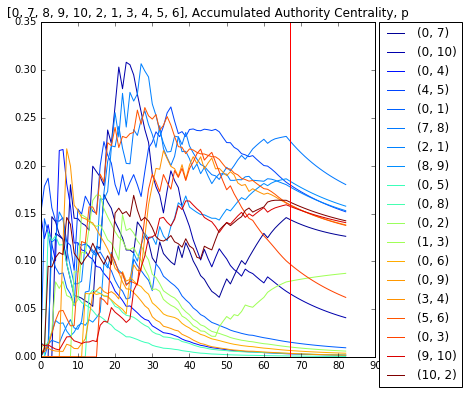

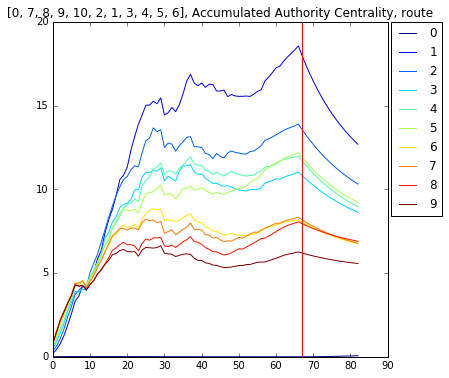

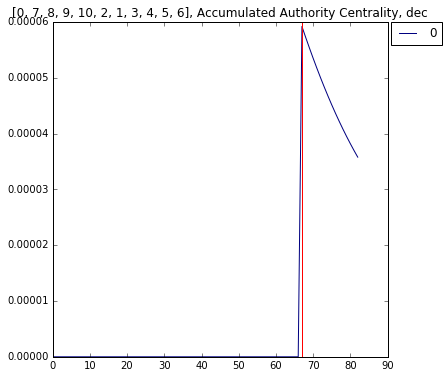

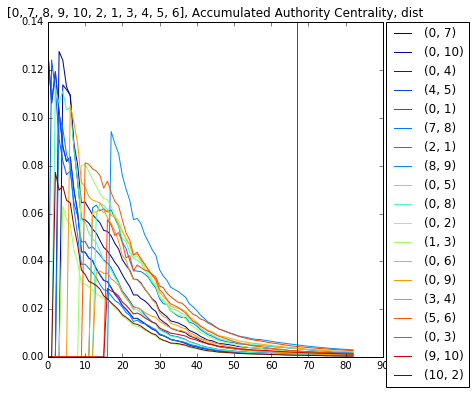

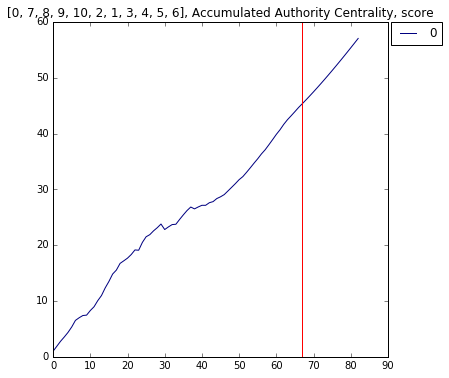

In [192]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    if s == 0:
        continue
    #print s
    (h,c)=nx.hits(kd,max_iter=10000,normalized=False) #(hubs,authorities)

    #c=nx.betweenness_centrality(kd,normalized=True)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=True
start_only=True
cmap=cm.get_cmap('jet')
x=range(t.step-1)
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        
        if type(e)==tuple:
            if (not dec_only) and (not start_only):
                plt.plot(x,series,label='{}'.format(e),color=c)
            
            elif ((e in e_r) and dec_only) or (e[0]==0 and start_only):
                plt.plot(x,series,label='{}'.format(e),color=c)
            
                
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Authority Centrality, {}'.format(t.d,k))

        
        
#print results

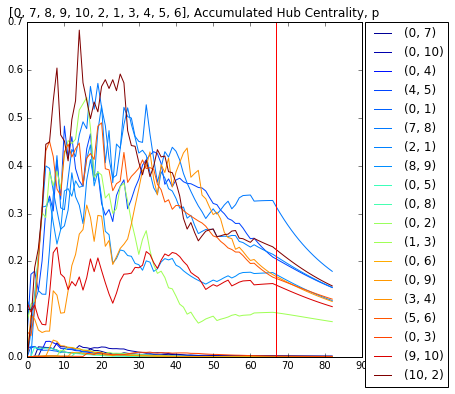

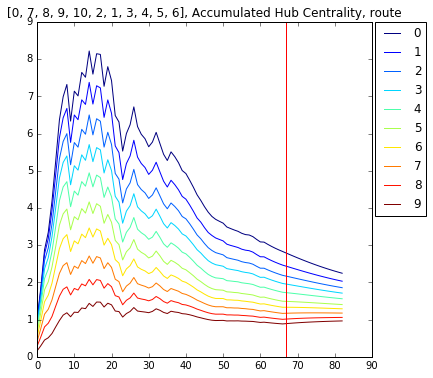

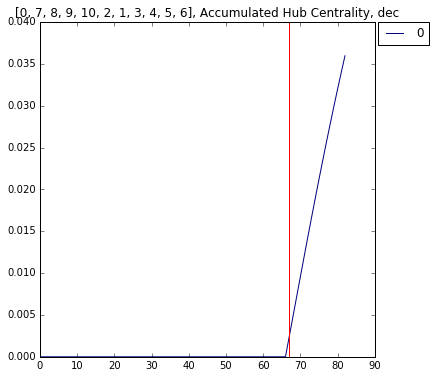

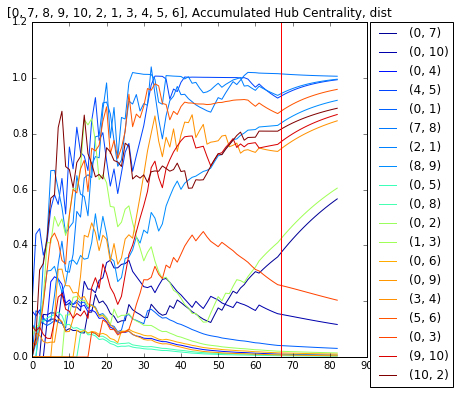

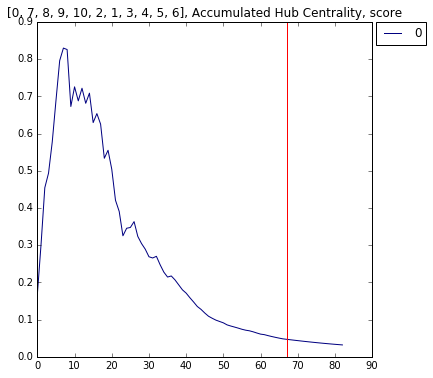

In [193]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    if s == 0:
        continue
    #print s
    (c,a)=nx.hits(kd,max_iter=10000,normalized=False) #(hubs,authorities)

    #c=nx.betweenness_centrality(kd,normalized=True)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=True
start_only=True
cmap=cm.get_cmap('jet')
x=range(t.step-1)
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        
        if type(e)==tuple:
            if (not dec_only) and (not start_only):
                plt.plot(x,series,label='{}'.format(e),color=c)
            
            elif ((e in e_r) and dec_only) or (e[0]==0 and start_only):
                plt.plot(x,series,label='{}'.format(e),color=c)
            
                
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Hub Centrality, {}'.format(t.d,k))

             
        
#print results

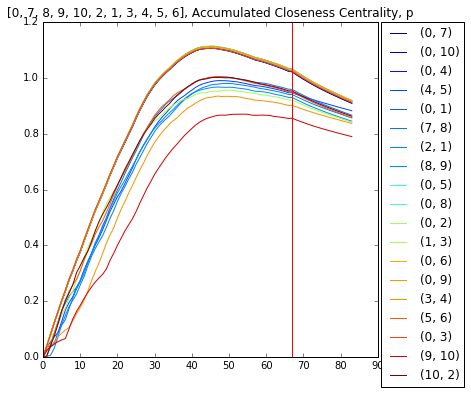

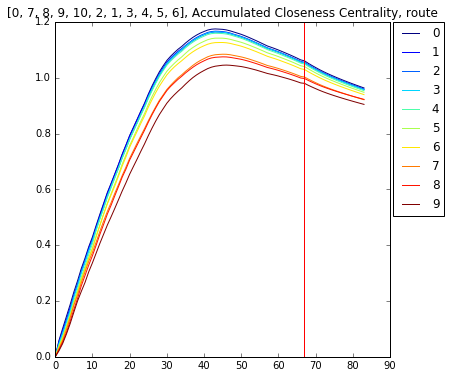

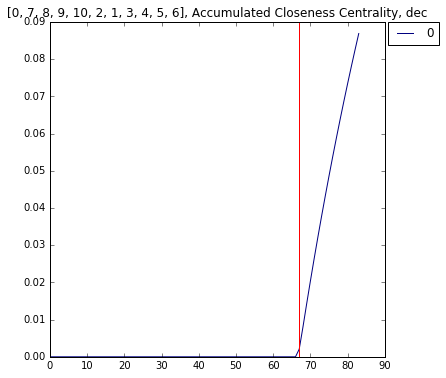

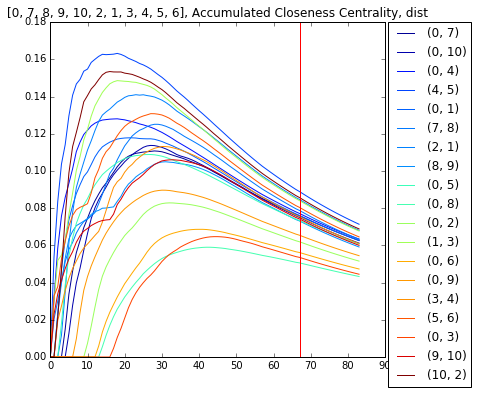

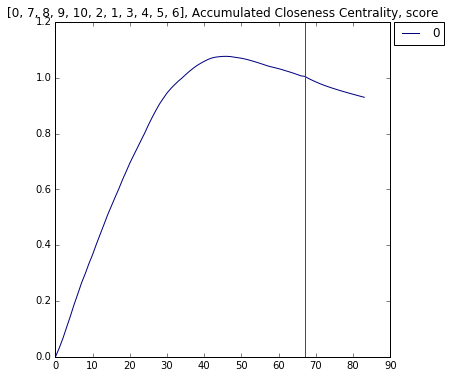

In [195]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        

results={}

for s,kd in t.history_k.iteritems():
    c=nx.closeness_centrality(kd,normalized=True)
    #c=nx.betweenness_centrality(kd,normalized=True)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)


        
        
#print results
#Plotting results
dec_only=True
start_only=True
cmap=cm.get_cmap('jet')
x=range(t.step)
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        
        if type(e)==tuple:
            if (not dec_only) and (not start_only):
                plt.plot(x,series,label='{}'.format(e),color=c)
            
            elif ((e in e_r) and dec_only) or (e[0]==0 and start_only):
                plt.plot(x,series,label='{}'.format(e),color=c)
            
                
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Closeness Centrality, {}'.format(t.d,k))

                
        
#print results

In [29]:
tsp=nx.DiGraph()
n_l=[1,2,3,4,5,6,7,8,9]
tsp.add_nodes_from(n_l)
#Edges:
#Distance=1 for nodes to the right and left
for i in xrange(len(n_l)):
    n=n_l[i]
    i_l=(i-1)%len(n_l)
    n_left=n_l[i_l]
    i_r=(i+1)%len(n_l)
    n_right=n_l[i_r]
    #print i, i_l,i_r, (n_l[i],n_l[i_l],n_l[i_r])
    tsp.add_edges_from([(n,n_left,{'dist':1.0}),(n,n_right,{'dist':1.0})])
    
#Non-adjacent edges: Distance=average of node labels
for i in tsp.nodes():
    for j in tsp.nodes():
        if i!=j:
            tsp.add_edge(i,j,dist=(i+j)/2.0)
    
#start node
tsp.add_node(0)
for n in tsp.nodes():
    if n!=0:
        tsp.add_edge(0,n,dist=0.0)

In [30]:
for u,v,d in tsp.edges(data=True):
    print (u,v), d

(0, 1) {'dist': 0.0}
(0, 2) {'dist': 0.0}
(0, 3) {'dist': 0.0}
(0, 4) {'dist': 0.0}
(0, 5) {'dist': 0.0}
(0, 6) {'dist': 0.0}
(0, 7) {'dist': 0.0}
(0, 8) {'dist': 0.0}
(0, 9) {'dist': 0.0}
(1, 2) {'dist': 1.5}
(1, 3) {'dist': 2.0}
(1, 4) {'dist': 2.5}
(1, 5) {'dist': 3.0}
(1, 6) {'dist': 3.5}
(1, 7) {'dist': 4.0}
(1, 8) {'dist': 4.5}
(1, 9) {'dist': 5.0}
(2, 1) {'dist': 1.5}
(2, 3) {'dist': 2.5}
(2, 4) {'dist': 3.0}
(2, 5) {'dist': 3.5}
(2, 6) {'dist': 4.0}
(2, 7) {'dist': 4.5}
(2, 8) {'dist': 5.0}
(2, 9) {'dist': 5.5}
(3, 1) {'dist': 2.0}
(3, 2) {'dist': 2.5}
(3, 4) {'dist': 3.5}
(3, 5) {'dist': 4.0}
(3, 6) {'dist': 4.5}
(3, 7) {'dist': 5.0}
(3, 8) {'dist': 5.5}
(3, 9) {'dist': 6.0}
(4, 1) {'dist': 2.5}
(4, 2) {'dist': 3.0}
(4, 3) {'dist': 3.5}
(4, 5) {'dist': 4.5}
(4, 6) {'dist': 5.0}
(4, 7) {'dist': 5.5}
(4, 8) {'dist': 6.0}
(4, 9) {'dist': 6.5}
(5, 1) {'dist': 3.0}
(5, 2) {'dist': 3.5}
(5, 3) {'dist': 4.0}
(5, 4) {'dist': 4.5}
(5, 6) {'dist': 5.5}
(5, 7) {'dist': 6.0}
(5, 8) {'dist

In [7]:
c=5
n_l=range(1,c+1)
print n_l

[1, 2, 3, 4, 5]


In [135]:
abs(1-2)

1